<a href="https://colab.research.google.com/github/dTenebrae/nlp/blob/main/lesson6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

In [ ]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en
clear_output()

Тут придется авторизировать запрос к гугл драйву, извините.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', 400)

In [ ]:

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [ ]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the sta..."
1,0,This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.<br /><br />It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing ...
2,1,"I simply love this movie. I also love the Ramones, so I am sorta biased to begin with in the first place. There isn't a lot of critical praise to give this film, either you like it or you don't. I think it's a great cult movie."
3,0,"Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no inten..."
4,1,"My all-time favorite movie! I have seen many movies, but this one beats them all! Excelent acting, wonderful story. You will, as a ""normal"" caring person start to love George. Altough he is an actor, he is also himself and a very lovable person. And maby most important thing: you will learn to respect & look different to people with Down Syndrome."


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [ ]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'refreshing', 'wonderfully', 'funniest', 'surprisingly', 'rare', 'superb', 'excellent', 'incredible', 'perfect', 'delightful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap','dull','worse','mildly','redeeming','baldwin','wooden','weak','badly','horrible','save','lame','mediocre','pointless','unfunny','forgettable','disappointing','boring','avoid','fails','awful','laughable','mess' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
# if accuracy > 0.71:
#     from IPython.display import Image, display
#     display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 73.03%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [ ]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [ ]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [ ]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [ ]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [ ]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

In [ ]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df, show=True):
    preds = model.predict(test_df['review'])
    acc = accuracy_score(test_df['is_positive'], preds)
    if show:
        print('Test accuracy = {:.2%}'.format(acc))
    return acc
    
eval_model(model, test_df)

Test accuracy = 86.50%


0.865

Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [ ]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [ ]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


0.88284

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [ ]:
ngram_list = [
              (1, 1),
              (1, 2),
              (1, 3),
              (1, 4),
              (1, 5),
              (2, 2),
              (2, 3),
              (2, 4),
              (2, 5),
              (3, 3),
              (3, 4),
              (3, 5),
]

In [ ]:
result = []
for ngram in ngram_list:
    vectorizer = TfidfVectorizer(ngram_range=ngram)
    classifier = LogisticRegression()

    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    model.fit(train_df['review'], train_df['is_positive'])

    result.append(eval_model(model, test_df, show=False))

In [ ]:
for tup, acc in zip(ngram_list, result):
    print(f"{tup} - {acc * 100:.2f}%")

(1, 1) - 88.28%
(1, 2) - 88.64%
(1, 3) - 87.76%
(1, 4) - 86.89%
(1, 5) - 86.28%
(2, 2) - 87.00%
(2, 3) - 86.40%
(2, 4) - 85.88%
(2, 5) - 85.36%
(3, 3) - 83.74%
(3, 4) - 83.30%
(3, 5) - 82.96%


Как можно увидеть, в нашем случае наилучший результат дает использование уни- и би- грамм

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.86%


0.87856

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [ ]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B ORG
, , O 
despite despite O 
its -PRON- O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it -PRON- O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithfu

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [ ]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [ ]:
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Создадим кастомный трансформер

In [ ]:
class TokenTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, func):
      self.func = func

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_ = X.copy()
    # токенизируем каждую строку
    X_ = X_.apply(word_tokenize)
    # применяем стеммер на каждый токен
    X_ = X_.apply(lambda x: " ".join(list(map(self.func, x))))
    return X_

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()
stem_tokenizer = TokenTransformer(stemmer.stem)

model = Pipeline([
    ('stem_token', stem_tokenizer),
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df);

Test accuracy = 88.64%


Аналогичным образом можно попробовать на леммах

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()
lemmatizer = TokenTransformer(lemmer.lemmatize)

model = Pipeline([
    ('stem_token', lemmatizer),
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df);

Test accuracy = 88.60%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [ ]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

Присоединим для удобства столбец с координатами сущностей к датафрейму train_df

In [ ]:
train_df["slices"] = pd.DataFrame(train_docs)[1]
test_df["slices"] = pd.DataFrame(test_docs)[1]

In [ ]:
train_df.head(3)

,is_positive,review,slices
0,0,"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the sta...","[(35, 39, PERSON), (48, 71, DATE), (75, 83, FAC), (447, 452, ORDINAL), (479, 482, CARDINAL), (712, 721, TIME), (863, 868, PERSON), (870, 885, PERSON), (1074, 1086, PERSON), (1087, 1095, ORG), (1354, 1369, PERSON), (1482, 1497, PERSON), (1505, 1510, ORDINAL), (1525, 1535, GPE), (1590, 1602, PERSON), (1655, 1666, PERSON), (1739, 1743, GPE), (1860, 1873, ORG), (1885, 1890, PERSON), (1898, 1913, P..."
1,0,This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style. It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations...,"[(334, 337, ORG), (357, 372, WORK_OF_ART), (613, 619, ORG), (1020, 1024, DATE), (1114, 1122, ORG), (1125, 1131, GPE), (1146, 1171, ORG), (1176, 1187, ORG)]"
2,1,"I simply love this movie. I also love the Ramones, so I am sorta biased to begin with in the first place. There isn't a lot of critical praise to give this film, either you like it or you don't. I think it's a great cult movie.","[(42, 49, ORG), (93, 98, ORDINAL)]"


In [ ]:
test_df.head(3)

,is_positive,review,slices
0,0,"A formulaic story with all the tired cliches. I was shocked that the horrible script became a movie! What a waste! How many ORIGINAL scripts are scattered around without being produced? At the climax I could predict what will happen in every single shot. Oh, and don't even get me started about the idiotic sexual tension between the gorgeous female cop and the paralyzed cop who can barely ...","[(124, 132, ORG)]"
1,1,"This is both an entertaining and a touching version of the classic tale, also quite intelligent, not of the 'Me Tarzan, You Jane' school at all. It's the famous story of a child reared to manhood in the jungle by apes. A titled British couple (the wife pregnant) is stranded in the African wilds after a shipwreck. After the parents' deaths, the baby is raised in the jungle by apes. Twenty year...","[(124, 128, PERSON), (229, 236, NORP), (283, 290, NORP), (385, 403, DATE), (426, 432, PERSON), (452, 459, NORP), (502, 509, NORP), (564, 573, PERSON), (616, 624, GPE), (705, 708, CARDINAL), (719, 733, DATE), (742, 748, PERSON), (937, 952, DATE), (959, 965, PERSON), (1045, 1052, NORP), (1083, 1087, PERSON), (1178, 1187, NORP), (1281, 1287, PERSON), (1294, 1314, ORG), (1360, 1366, GPE), (1495, 1..."
2,0,"Corey Haim is never going to be known as one of the great actors of his time, but at least in movies like ""Licensed To Drive"", he was more in his element... lowbrow humor. Dean Koontz's book ""Watchers"" was one of his earlier works, and still probably his finest to date. Sadly, this magnificent tale of a brilliant dog, a deranged mutant and a genetic experiment gone wrong is butchered horribly...","[(0, 10, PERSON), (41, 44, CARDINAL), (106, 125, WORK_OF_ART), (173, 186, PERSON), (193, 201, WORK_OF_ART), (207, 210, CARDINAL), (599, 621, WORK_OF_ART), (673, 685, GPE), (827, 829, ORG), (863, 874, PERSON)]"


In [ ]:
def replace_ent(text, slices, ent="PERSON"):
    """
    text: строка, в которой будем осуществлять замены
    slices: список координат именованных сущностей
    ent: имя сущности, которую мы хотим заменить
    """
    new_text = text
    for tup in slices:
        # если мы нашли искомую сущность
        if tup[2] == ent:
            # берем строку по координатам
            ent_to_replace = text[tup[0]:tup[1]]
            # так как длина строки будет изменяться, модифиировать мы будем новую строку
            new_text = new_text.replace(ent_to_replace, ent, 1)
    return new_text

In [ ]:
# перед применением к датафрейму посмотрим, как работает функция
replace_ent(train_df.iloc[0]["review"], train_df.iloc[0]["slices"])

'Dreamgirls, despite its fistful of PERSON wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of PERSON (PERSON). The film is slick and technically well-produced, but the story and characters are surprisingly thin and lacking in an

In [ ]:
train_df["review"] = train_df.apply(lambda x: replace_ent(x["review"], x["slices"]), axis=1)
train_df.drop(["slices"], axis=1, inplace=True)
test_df["review"] = test_df.apply(lambda x: replace_ent(x["review"], x["slices"]), axis=1)
test_df.drop(["slices"], axis=1, inplace=True)

In [ ]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of PERSON wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the s..."
1,0,This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style. It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations...
2,1,"I simply love this movie. I also love the Ramones, so I am sorta biased to begin with in the first place. There isn't a lot of critical praise to give this film, either you like it or you don't. I think it's a great cult movie."
3,0,"Spoilers ahead if you want to call them that... I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top... THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or ""effort"". T..."
4,1,"My all-time favorite movie! I have seen many movies, but this one beats them all! Excelent acting, wonderful story. You will, as a ""normal"" caring person start to love PERSON. Altough he is an actor, he is also himself and a very lovable person. And maby most important thing: you will learn to respect & look different to people with PERSON."


Посмотрим, как покажет себя это преобразование вместе с лемматизацией текстов

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()
lemmatizer = TokenTransformer(lemmer.lemmatize)

model = Pipeline([
    ('stem_token', lemmatizer),
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df);

Test accuracy = 88.50%


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [ ]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the sta...
1        This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.  It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations...
2                                                                                                                                                                                    I

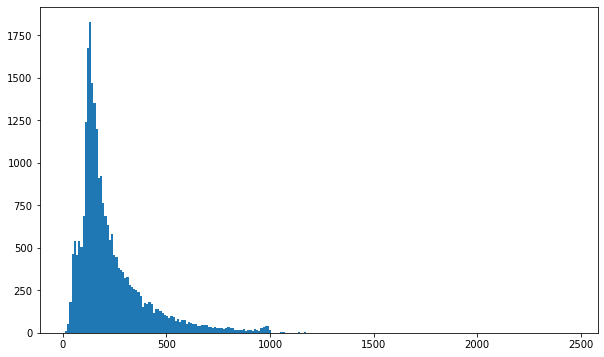

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist;

Кроме этого, нужно перенумеровать как-то слова.

In [ ]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [ ]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1714112   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 16s 75ms/step - loss: 0.6170 - accuracy: 0.7404 - val_loss: 0.4198 - val_accuracy: 0.8357
Epoch 2/10
196/196 [==============================] - 14s 74ms/step - loss: 0.3065 - accuracy: 0.8757 - val_loss: 0.3027 - val_accuracy: 0.8711
Epoch 3/10
196/196 [==============================] - 15s 74ms/step - loss: 0.1869 - accuracy: 0.9314 - val_loss: 0.2904 - val_accuracy: 0.8772
Epoch 4/10
196/196 [==============================] - 14s 73ms/step - loss: 0.1082 - accuracy: 0.9646 - val_loss: 0.3102 - val_accuracy: 0.8752
Epoch 5/10
196/196 [==============================] - 14s 73ms/step - loss: 0.0552 - accuracy: 0.9868 - val_loss: 0.3483 - val_accuracy: 0.8726
Epoch 6/10
196/196 [==============================] - 14s 73ms/step - loss: 0.0259 - accuracy: 0.9959 - val_loss: 0.3822 - val_accuracy: 0.8710
Epoch 7/10
196/196 [==============================] - 14s 74ms/step - loss: 0.0118 - accuracy: 0.9989 - val_loss: 0.4156 - val_accuracy:

**Задание** Подсчитайте качество модели на тесте

In [ ]:
preds = model.predict(X_test)

Так как сеть нам дает итоговую вероятность принадлежности к классу, можем определить порог, при котором мы получаем наилучшую метрику

In [ ]:
thr_list = np.arange(0, 1.1, 0.1)
acc_list = []
for thr in thr_list:
    preds_thr = np.where(preds > thr, 1, 0).flatten()
    acc = accuracy_score(test_df['is_positive'], preds_thr)
    acc_list.append(acc)

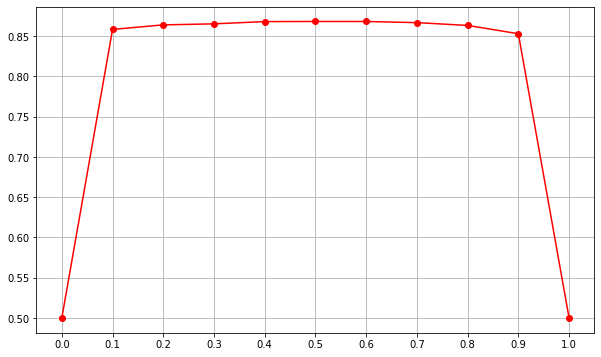

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(thr_list, acc_list, marker='o', color='red')
plt.xticks(thr_list)
plt.grid()
plt.show()

In [ ]:
# итого, лучшая метрика:
print(f"accuracy on test: {acc_list[5]*100:.2f}%")

accuracy on test: 86.83%
